## Imports

In [1]:
import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using ProgressMeter
using LoggingExtras
using Revise
using Dates
using YAXArrays

import LsqFit as LF


In [2]:
import SuperconductingCavities as SC

## Logger Setups

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(InfoLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Checking Collapse and Dephasing Ops

Image of the code used to construct the ops. Found in SuperconductingCavities/src/Circuits/Ciruit_Types/Transmon_Resonators/Constructor.jl

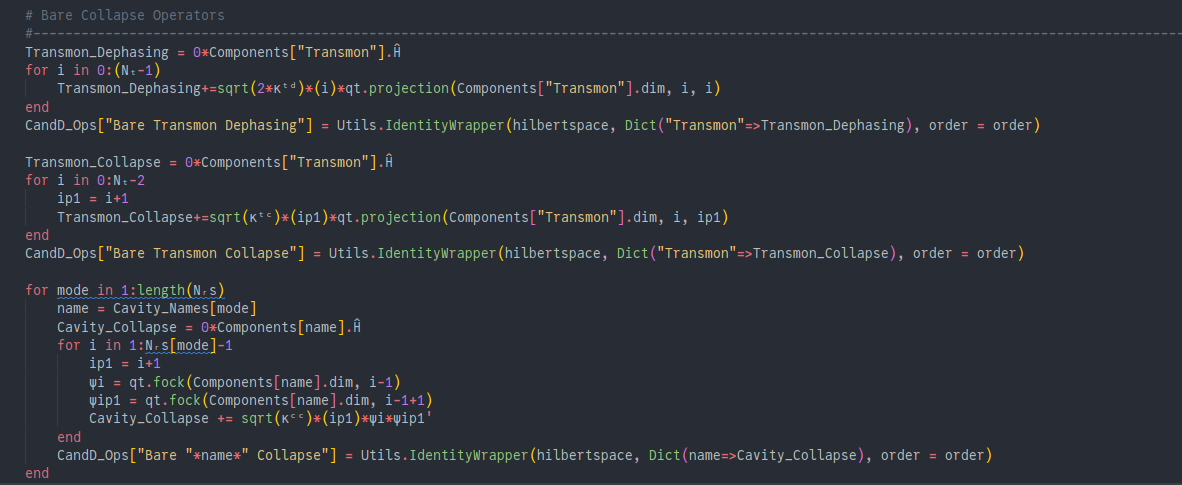

In [4]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

In [3]:
CandD_Check = SC.Utils.LoadRunResults("Data/CheckingCollapseAndDephasing_with2.nc", cube_order = ["CheckingCollapseAndDephasing_with2"])

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8  …  1998.2, …
  "states" => Any[Quantum Object:   type=Operator   dims=[10, 10]   size=(100, …

In [8]:
Proj_Ops_Temp = SC.Utils.Get_Projection_Ops(Dict{Any, Any}((0,0) => Mode3.dressed_states[(0,0)], (1,0) => Mode3.dressed_states[(1,0)]))

EVs = SC.Utils.Get_EVs(CandD_Check["states"], Proj_Ops_Temp)

Dict{Any, Any} with 2 entries:
  (0, 0) => ComplexF64[0.5+0.0im, 0.500002+6.22183e-21im, 0.500004+9.80493e-21i…
  (1, 0) => ComplexF64[0.5+0.0im, 0.499998+3.94517e-20im, 0.499996-1.17931e-20i…

In [9]:
g0 = Mode3.dressed_states[(0,0)]
e0 = Mode3.dressed_states[(1,0)]

e_diag = []
off_diag = []

for i in 1:length(CandD_Check["states"])
    ρ = CandD_Check["states"][i]
    push!(e_diag, e0'*ρ*e0)
    push!(off_diag, g0'*ρ*e0)
end

In [11]:
to_fit(t, p) = 0.5*ℯ.^(-t.*p)

y = abs.(e_diag)
x = CandD_Check["times"]

kappa1_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1]


y = abs.(off_diag)
x = CandD_Check["times"]

kappa2_Fit = LF.curve_fit(to_fit, x, y, [1e-6]).param[1];

In [12]:
println("kappa1_Fit: $kappa1_Fit")
println("kappa2_Fit: $kappa2_Fit")

kappaϕ_Fit = (kappa2_Fit-kappa1_Fit/2)
println("kappaϕ_Fit: $kappaϕ_Fit")



kappa1_Fit: 1.7867612935977286e-5
kappa2_Fit: 2.126525652146316e-5
kappaϕ_Fit: 1.2331450053474517e-5


In [15]:
println("Used kappa1: $(Mode3.params["kappa_tc"])")

kappa2 = Mode3.params["kappa_tc"]/2 + Mode3.params["kappa_td"]
println("Used kappa2: $(kappa2)")

println("Used kappaϕ: $(Mode3.params["kappa_td"])")

Used kappa1: 1.7857142857142855e-5
Used kappa2: 2.1276595744680852e-5
Used kappaϕ: 1.2348024316109425e-5


In [16]:
println("Experiment kappa1: $(1/56/1000)")
println("Experiment kappa2: $(1/47/1000)")

kappaϕ_exp = 1/47/1000 - 1/56/1000/2
println("Experiment kappaϕ: $kappaϕ_exp")

Experiment kappa1: 1.7857142857142855e-5
Experiment kappa2: 2.1276595744680852e-5
Experiment kappaϕ: 1.2348024316109425e-5
